## Classify well position

In [1]:
import pandas as pd
profiles = pd.read_parquet("../1.load/output/full_processed_profiles.parquet")

In [2]:
profiles['Metadata_Row'] = profiles['Metadata_Well'].str[0].map(lambda x: ord(x) - ord('A') + 1)
profiles['Metadata_Col'] = profiles['Metadata_Well'].str[1:].astype(int)

In [3]:
import numpy as np

np.random.seed(42)

# n_platemaps_sample = 20

# # Select random plate maps
# random_platemaps = np.random.choice(profiles['Metadata_plate_map_name'].unique(), n_platemaps_sample, replace=False)

# # Select all wells from these plates
# profiles = profiles[profiles['Metadata_plate_map_name'].isin(random_platemaps)]


In [4]:
import numpy as np

prefixes = ["Cells_", "Nuclei_", "Cytoplasm_", "Image_"]
profiles = profiles[
    ["Metadata_plate_map_name", "Metadata_Plate", "Metadata_Well", "Metadata_Row", "Metadata_Col"]
    + [
        col
        for col in profiles.columns
        if any(col.startswith(prefix) for prefix in prefixes)
    ]
]

features = [
    col
    for col in profiles.columns
    if any(col.startswith(prefix) for prefix in prefixes)
]


In [5]:
n_train_platemaps = 15

train_platemaps = np.random.choice(profiles['Metadata_plate_map_name'].unique(), n_train_platemaps, replace=False)
test_platemaps = profiles['Metadata_plate_map_name'].unique()[~np.isin(profiles['Metadata_plate_map_name'].unique(), train_platemaps)]

profiles_train = profiles[profiles['Metadata_plate_map_name'].isin(train_platemaps)]
profiles_test = profiles[profiles['Metadata_plate_map_name'].isin(test_platemaps)]

X = profiles[features]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features = X.columns.tolist()

X_train = profiles_train[features]
X_test = profiles_test[features]

y_train = profiles_train[['Metadata_Row', 'Metadata_Col']]
y_test = profiles_test[['Metadata_Row', 'Metadata_Col']]


In [6]:
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# feature selection
selector = SelectFromModel(estimator=Lasso(alpha=0.1))

# model
xgb_regressor = XGBRegressor(random_state=42, n_estimators=100, n_jobs=-1, objective='reg:squarederror')

# we create a pipeline to connect both steps: feature selection and model
pipeline = Pipeline(steps=[('s', selector), ('m', MultiOutputRegressor(xgb_regressor))])

# normalize features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [7]:
# fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# predict the test set results
y_pred = pipeline.predict(X_test)

# calculate the Euclidean distance
euclidean_distances = np.linalg.norm(y_test.values - y_pred, axis=1)
average_euclidean_distance = np.mean(euclidean_distances)

print(f'Average Euclidean distance: {average_euclidean_distance}')

Average Euclidean distance: 3.020866562206935


In [13]:
# Add the euclidean_distances as a new column to y_test
y_test = y_test.copy()
y_test['Euclidean_Distance'] = euclidean_distances

# Group by Metadata_Row and Metadata_Col and calculate the mean Euclidean distance
avg_euc_distances_df = y_test.groupby(['Metadata_Row', 'Metadata_Col']).Euclidean_Distance.mean().reset_index()
std_euc_distances_df = y_test.groupby(['Metadata_Row', 'Metadata_Col']).Euclidean_Distance.std().reset_index()

avg_heatmap = avg_euc_distances_df.pivot(index='Metadata_Row', columns='Metadata_Col', values='Euclidean_Distance')
std_heatmap = std_euc_distances_df.pivot(index='Metadata_Row', columns='Metadata_Col', values='Euclidean_Distance')


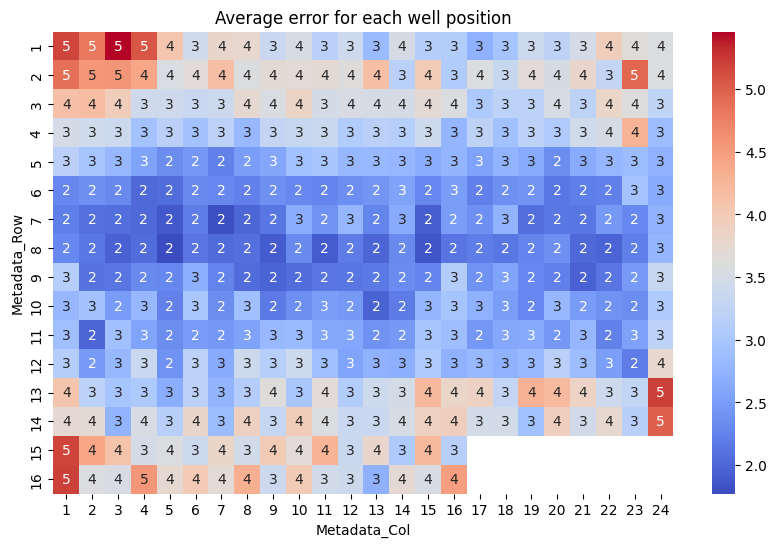

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
sns.heatmap(avg_heatmap, cmap='coolwarm', annot=True, fmt='.0f')
plt.title('Average error for each well position')
plt.show()



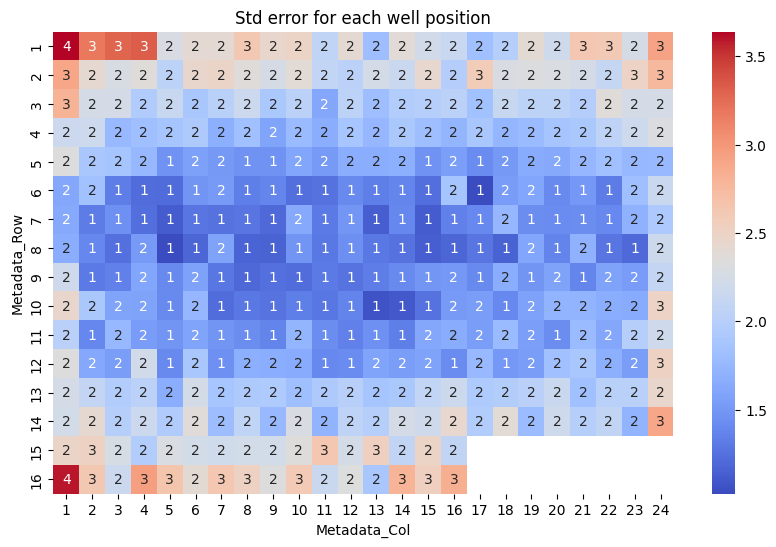

In [16]:

plt.figure(figsize=(10,6))
sns.heatmap(std_heatmap, cmap='coolwarm', annot=True, fmt='.0f')
plt.title('Std error for each well position')
plt.show()